In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint

## A genetic toggle switch

### Question 1.1

In [2]:
#function for use with odeint

def tog_switch_round(uv, t, parameters):
    iu, iv, au, av, k, b, n = parameters
    u, v = uv
    du = -uv[0] + au / (1 + (v / (1 + iv / k)**n)**b)
    dv = -uv[1] + av / (1 + (u / (1 + iu / k)**n)**b)
    return [du, dv]

### Question 1.2

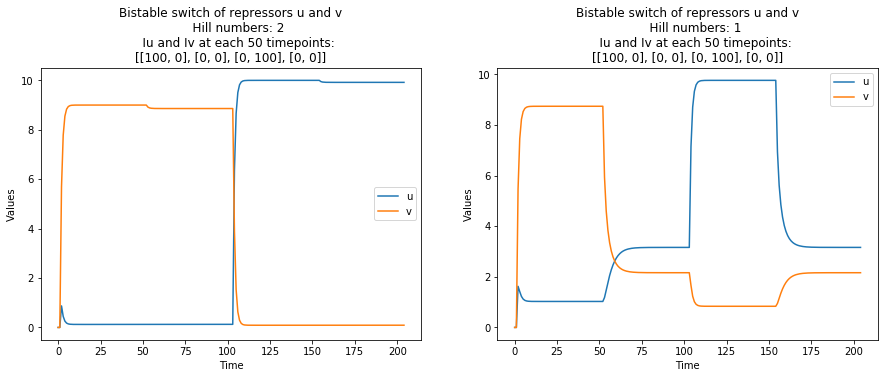

In [3]:
#define how many timepoints to use per odeint call
t=50
timepoints = np.linspace(0, t, t+1)

#define the values for Iu and Iv in each odeint call
induction_steps = [[100,0], [0,0] ,[0,100] ,[0,0]]

#x axis for plotting should go from 0 to the # of timepoints times the # of Iu/Iv pairs
x_axis = np.linspace(0, (t+1)*len(induction_steps), (t+1)*len(induction_steps)+1)

#define remaining constants for odeint
constants = [0, 0, 10, 9, 3, 2, 2]
test_hill = [2, 1]

plt.figure(figsize=(15,5))

#loop through each thing that varies in this exercise and plot as subplots
for i in range(len(test_hill)):
    tot_results = np.array([[0., 0.]])
    for step in induction_steps:
        constants[0] = step[0]
        constants[1] = step[1]
        constants[-1], constants[-2] = [test_hill[i], test_hill[i]]
        result = odeint(tog_switch_round, y0=tot_results[-1], t=timepoints, args=(constants,))
        tot_results = np.concatenate((tot_results, result))
    u = tot_results[:,0]
    v = tot_results[:,1]
    plt.subplot(1, 2, i+1)
    plt.plot(x_axis, u, label="u")
    plt.plot(x_axis, v, label="v")

    plt.title("Bistable switch of repressors u and v\n\
    Hill numbers: {}\n\
    Iu and Iv at each {} timepoints:\n{}".format(constants[-1], t, induction_steps))

    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
plt.show()

With Hill numbers equal to 2, it is possible to see hysteresis. In the time frames 50 to 100 and 150 to 200 the parameters are the same, but the steady-state values are different, because they depend on the previous values for u and v. Starting the system with Iu and Iv at (0, 0) would leave U in the 'ON' state, but as between timepoints 50 and 100 there was already a large quantity of v, that repressed u. This is a positive feedback that mantains v in its 'ON' state.<br><br>
Changing the Hill numbers to 1, hysteresis is lost, because independing of where the values are coming from, they return to the same steady-state, which is not 'ON' for any of the variables, but an intermediary state.

### Question 1.3

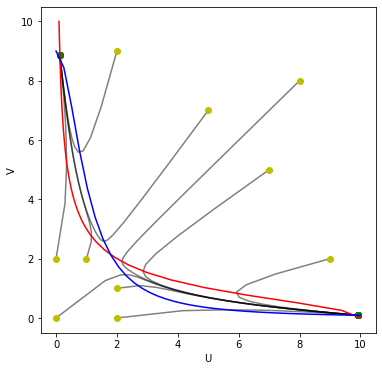

In [4]:
t=50
timepoints = np.linspace(0, t, 3*(t+1)) # using many intervals between 0 and t to make lines smoother

#initial values hand-picked to show the different possible trajectories
initial_values = [[0, 0], [1, 2], [2, 1], [5, 7], [7, 5], [9, 2], [2, 9], [0, 2], [2, 0], [8, 8]]
constants = [0, 0, 10, 9, 3, 2, 2]

plt.figure(figsize=(6, 6))
plt.xlabel("U")
plt.ylabel("V")

for value in initial_values:
    result = odeint(tog_switch_round, y0=[value[0], value[1]], t=timepoints, args=(constants,))
    u = result[:,0]
    v = result[:,1]
    plt.plot(u, v, 'k', alpha=(0.5))
    plt.plot(u[-1], v[-1], 'go')
    plt.plot(u[0], v[0], 'yo')

#best way to plot nullclines seems to be list comprehensions
nuc_values = np.linspace(0, 10, 4*10)
u_ncl = [10 / (1 + v**2) for v in nuc_values]
v_ncl = [9 / (1 + u**2) for u in nuc_values]

plt.plot(u_ncl, nuc_values, 'r')
plt.plot(nuc_values, v_ncl, 'b')
plt.show()

The points (10, 0) and (0, 9) mark the values of the steady-states. If u starts high, its higher maximum value will make it repress v to 0 and set it's own value to it's maximum (au=10). However, because of positive feedback, there is hysteresis, so if v starts high, it is able to repress u and the system tends to the v 'ON' state at (0, 9).

### Question 1.4

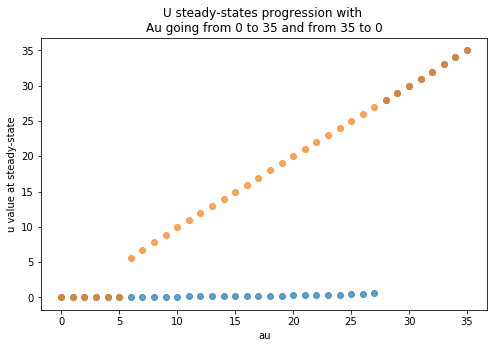

In [5]:
#define values of au in each run of odeint
fw = np.linspace(0, 35, 36)
rv = fw[::-1]
runs = [fw, rv]


constants = [0, 0, 0, 9, 3, 2, 2]

#run odeint for each au progression and plot
plt.figure(figsize = (8, 5))
for run in runs:
    last_result = [[0, 0]]
    u_ends = []
    for au in run:
        constants[2] = au
        result = odeint(tog_switch_round, y0=last_result[-1], t=timepoints, args=(constants,))
        u_ends.append(result[-1, 0])
        last_result.append(result[-1])
    plt.plot(run, u_ends, "o", alpha=0.7)
plt.title("U steady-states progression with \nAu going from 0 to 35 and from 35 to 0")
plt.xlabel("au")
plt.ylabel("u value at steady-state")
plt.show()

While au is increasing from 0 to 35, u stays in its 'OFF' state until about when au=26. However, with au going back to 0, u only resets to the 'OFF' state at about au=6. This happens again due to hysteresis created from the positive feedback of repressing the other variable v.

## A genetic oscilator

### Question 2.1

The system has negative feedback because, for each variable, its increase leads to the increase of a factor that will affect the first variable negatively. An even number of coupled repressors gives positive feedback, as seen with the bi-stable switch, and an odd number gives negative.<br><br>
In this example, the expression of protein 1 represses the expression of protein 2, which in turns allows expression of protein 3, that ends up closing the cycle with repression of 1.

### Question 2.2

In [6]:
#function will take variables: [m1, m2, m3, p1, p2, p3] and output the same

def oscilator_round(variables, t, a, b):
    m_output = []
    p_output = []
    for n in range(int(len(variables)/2)):
        m_output.append(-variables[n] + a/(1+variables[(n+2)%3+3]**2))
        p_output.append(-b * (variables[n+3] - variables[n]))
    return np.concatenate((m_output, p_output))

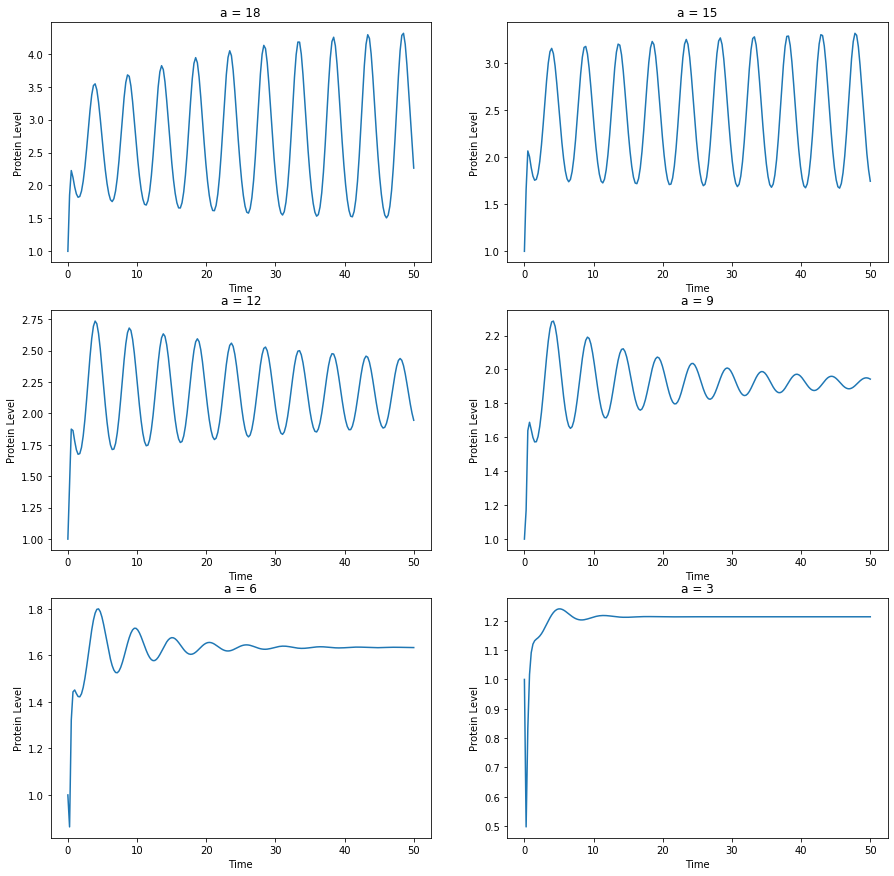

In [7]:
initial_values = [0, 0, 0, 1, 0, 0]

t=50
timepoints = np.linspace(0, t, 4*(t+1))

plt.figure(figsize=(15, 15))
# loop through a values and plot only protein 1
for n in range(6):
    constants = ((6-n)*3, 10)
    osc_result = odeint(oscilator_round, y0=initial_values, t=timepoints, args=constants)
    y = osc_result[:,3]
    plt.subplot(3, 2, n+1)
    plt.title("a = {}".format((6-n)*3))
    plt.xlabel("Time")
    plt.ylabel("Protein Level")
    plt.plot(timepoints, y)
plt.show()


### Question 2.3

In [8]:
#setting run time to 200 to get late-setting steady states
t=200
timepoints = np.linspace(0, t, num=4*(t+1))
x_axis = np.linspace(0, t, 4*(t+1))


a_space = np.logspace(0, 3, num=20)
b_space = np.logspace(-1, 3, num=20)
initial_values = [1, 4, 1, 2, 1, 1]
z_values = []
plot = False #controller for plotting the data or not

for b in b_space:
    z_row = []
    for a in a_space:
        osc_result = odeint(oscilator_round, y0=initial_values, t=timepoints, args=(a, b))
        y = osc_result[-50:,3]
        mean_diff = np.mean(np.absolute(np.diff(y)))
        if plot:
            plt.figure()
            plt.title("a = {}, b = {}\nmean absolute difference between timepoints in\n \
            last 50 timepoints: {}".format(round(a, 2), round(b, 2), mean_diff))
            plt.plot(x_axis, osc_result[:,3])
            plt.show()
        
        #filter graphs with steady-states or small oscilations.
        #High mean differences between points means lots of oscilation
        #We won't differentiate oscilation characteristics,
        #this will test qualitatively and arbitrarily for 'big oscilations'
        if mean_diff > 10e-5:
            z_row.append(1)
        else:
            z_row.append(-1)
        #z_row.append(np.log(mean_diff))
    z_values.append(z_row)

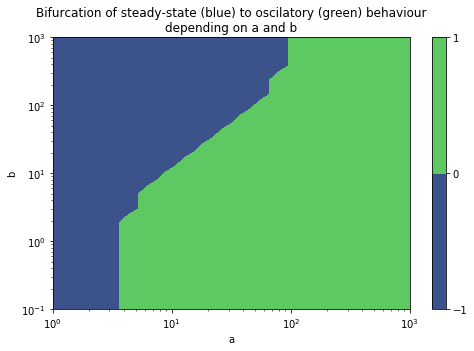

In [9]:
plt.figure(figsize=(8,5))

plt.contourf(a_space, b_space, z_values, 1)
plt.xscale('log')
plt.yscale('log')
plt.title("Bifurcation of steady-state (blue) to oscilatory (green) behaviour\ndepending on a and b")
plt.xlabel("a")
plt.ylabel("b")
plt.colorbar()
plt.show()

In this model, b represents the ratio between protein lifetime and RNA lifetime. For low degradation rates of protein, then, b is high, expanding the steady-state area in the graph. This happens because proteins must follow the mRNA dinamics, or else there may be leftover protein in the system when its transcription is already repressed. This would cause an overall decrease in amplitude of the oscilations until a stable steady-state is reached.
However, with a high 'a' value, the oscilations are restored. 'a' represents the maximum mRNAs transcribed per unit of time, so it acts like a counterbalance to b, making the protein concentrations more dependant on transcription rather than degradation, because it is like if the mRNA lifetime was getting larger (relative to the rest of the RNA's dynamics), thus having an effect like if b got smaller. 